In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
import math
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.svm import SVR
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk9gd_5day.xlsx'
data = pd.read_excel(path, date_parser=[0])
# İlk 5 Satır
data.head()

,DATE_TIME,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2022-01-06 00:00:00,154,5,78,175
1,2022-01-06 01:00:00,146,17,77,137
2,2022-01-06 02:00:00,134,7,70,86
3,2022-01-06 03:00:00,146,6,79,69
4,2022-01-06 04:00:00,169,8,73,105


In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M:%S')
#İndex'e Alınması
data.index = data.DATE_TIME

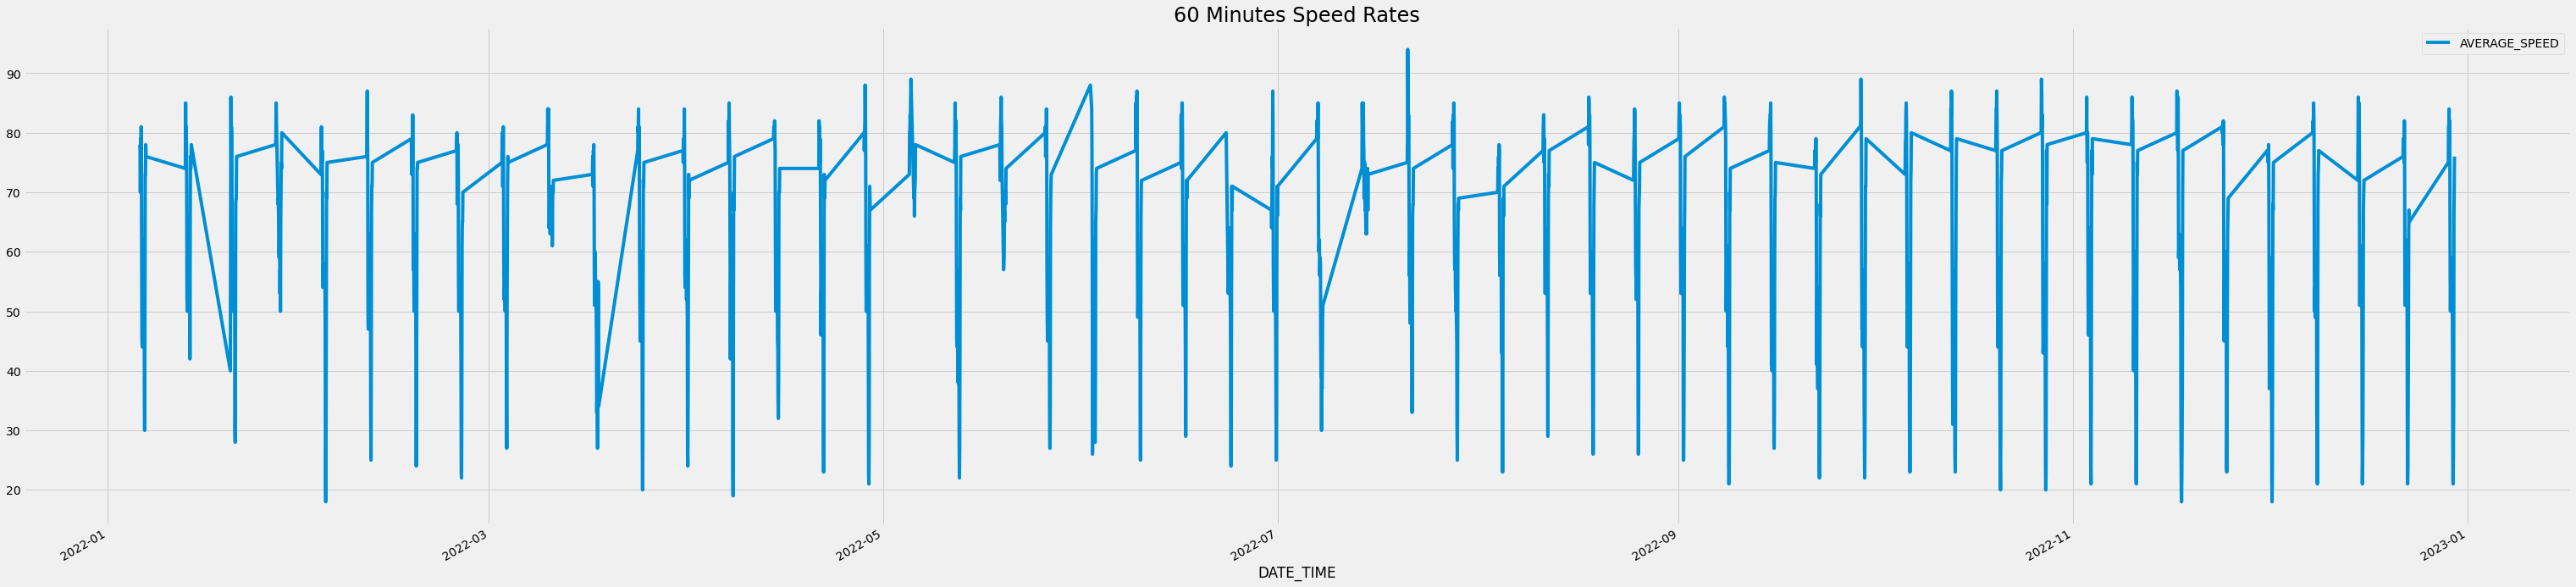

In [4]:
fig = plt.figure(figsize=(48,12))
data.AVERAGE_SPEED.plot(label='AVERAGE_SPEED')
plt.legend(loc='best')
plt.title('60 Minutes Speed Rates', fontsize=24)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Veri Örneği Sayıları (training set, test set): " + str((len(train), len(test))))

Veri Örneği Sayıları (training set, test set): (730, 488)


In [8]:
dataset

array([[0.7894737 ],
       [0.77631575],
       [0.68421054],
       ...,
       [0.631579  ],
       [0.71052635],
       [0.7631579 ]], dtype=float32)

In [31]:
def create_datasetMultiSteps(dataset, n_steps_out, window_size):
        dataX, dataY = [], []
        tot = window_size + n_steps_out - 1
        for i in range(int((len(dataset) - tot))):
                start_a = i
                end_a = start_a + window_size
                start_b = end_a
                end_b = end_a + n_steps_out
                a = dataset[start_a:end_a, 0]
                b = dataset[start_b:end_b, 0]
                dataX.append(a)
                dataY.append(b)
        return np.array(dataX), np.array(dataY)

In [32]:
# Verisetlerimizi Oluşturalım
window_size = 6
n_steps_out = 3
x_train, y_train = create_datasetMultiSteps(train,n_steps_out, window_size)
x_test, y_test = create_datasetMultiSteps(test,n_steps_out, window_size)
print("Original training data shape:")
print(x_train.shape)

Original training data shape:
(722, 6)


In [13]:
model = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model.fit(x_train, y_train[:,0])
model1 = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model1.fit(x_train, y_train[:,1])
model2 = SVR(kernel='rbf',gamma=0.75, C=10, epsilon = 0.005)
model2.fit(x_train, y_train[:,2])
SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.005, gamma=10.05,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=100, epsilon=0.005, gamma=10.05)

In [14]:
model.get_params()

{'C': 10,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.005,
 'gamma': 0.75,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [15]:
y1_train_pred = model.predict(x_train).reshape(-1,1)
y2_train_pred = model1.predict(x_train).reshape(-1,1)
y3_train_pred = model2.predict(x_train).reshape(-1,1)
y1_test_pred = model.predict(x_test).reshape(-1,1)
y2_test_pred = model1.predict(x_test).reshape(-1,1)
y3_test_pred = model2.predict(x_test).reshape(-1,1)

In [18]:
# Scaling the predictions
y1_train_pred = scaler.inverse_transform(y1_train_pred)
y2_train_pred = scaler.inverse_transform(y2_train_pred)
y3_train_pred = scaler.inverse_transform(y3_train_pred)
y1_test_pred = scaler.inverse_transform(y1_test_pred)
y2_test_pred = scaler.inverse_transform(y2_test_pred)
y3_test_pred = scaler.inverse_transform(y3_test_pred)
y_train_pred = concatenate(( y1_train_pred, y2_train_pred, y3_train_pred), axis=1)
y_test_pred = concatenate(( y1_test_pred, y2_test_pred, y3_test_pred), axis=1)

# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [19]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)
score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 9.13 RMSE
Test data score: 10.19 RMSE


In [20]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)
error_mape_t0 = 100*mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
print("Test t zamanı score: %.2f MAPE" % error_mape_t0)
error_mape_t1 = 100*mean_absolute_percentage_error(y_test[:,1], y_test_pred[:,1])
print("Test t+1 zamanı score: %.2f MAPE" % error_mape_t1)
error_mape_t2 = 100*mean_absolute_percentage_error(y_test[:,2], y_test_pred[:,2])
print("Test t+2 zamanı score: %.2f MAPE" % error_mape_t2)

Train data score: 12.87 MAPE
Test data score: 18.09 MAPE
Test t zamanı score: 12.77 MAPE
Test t+1 zamanı score: 19.84 MAPE
Test t+2 zamanı score: 21.64 MAPE


In [21]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 5.97 MdAPE
Test data score: 7.01 MdAPE


In [22]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)
error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 33.83 SMAPE
Test data score: 43.67 SMAPE


In [23]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 0.92 MASE
Test data score: 0.99 MASE


In [24]:
train_y=y_train
pred_train_y=y_train_pred
test_y=y_test
pred_test_y=y_test_pred

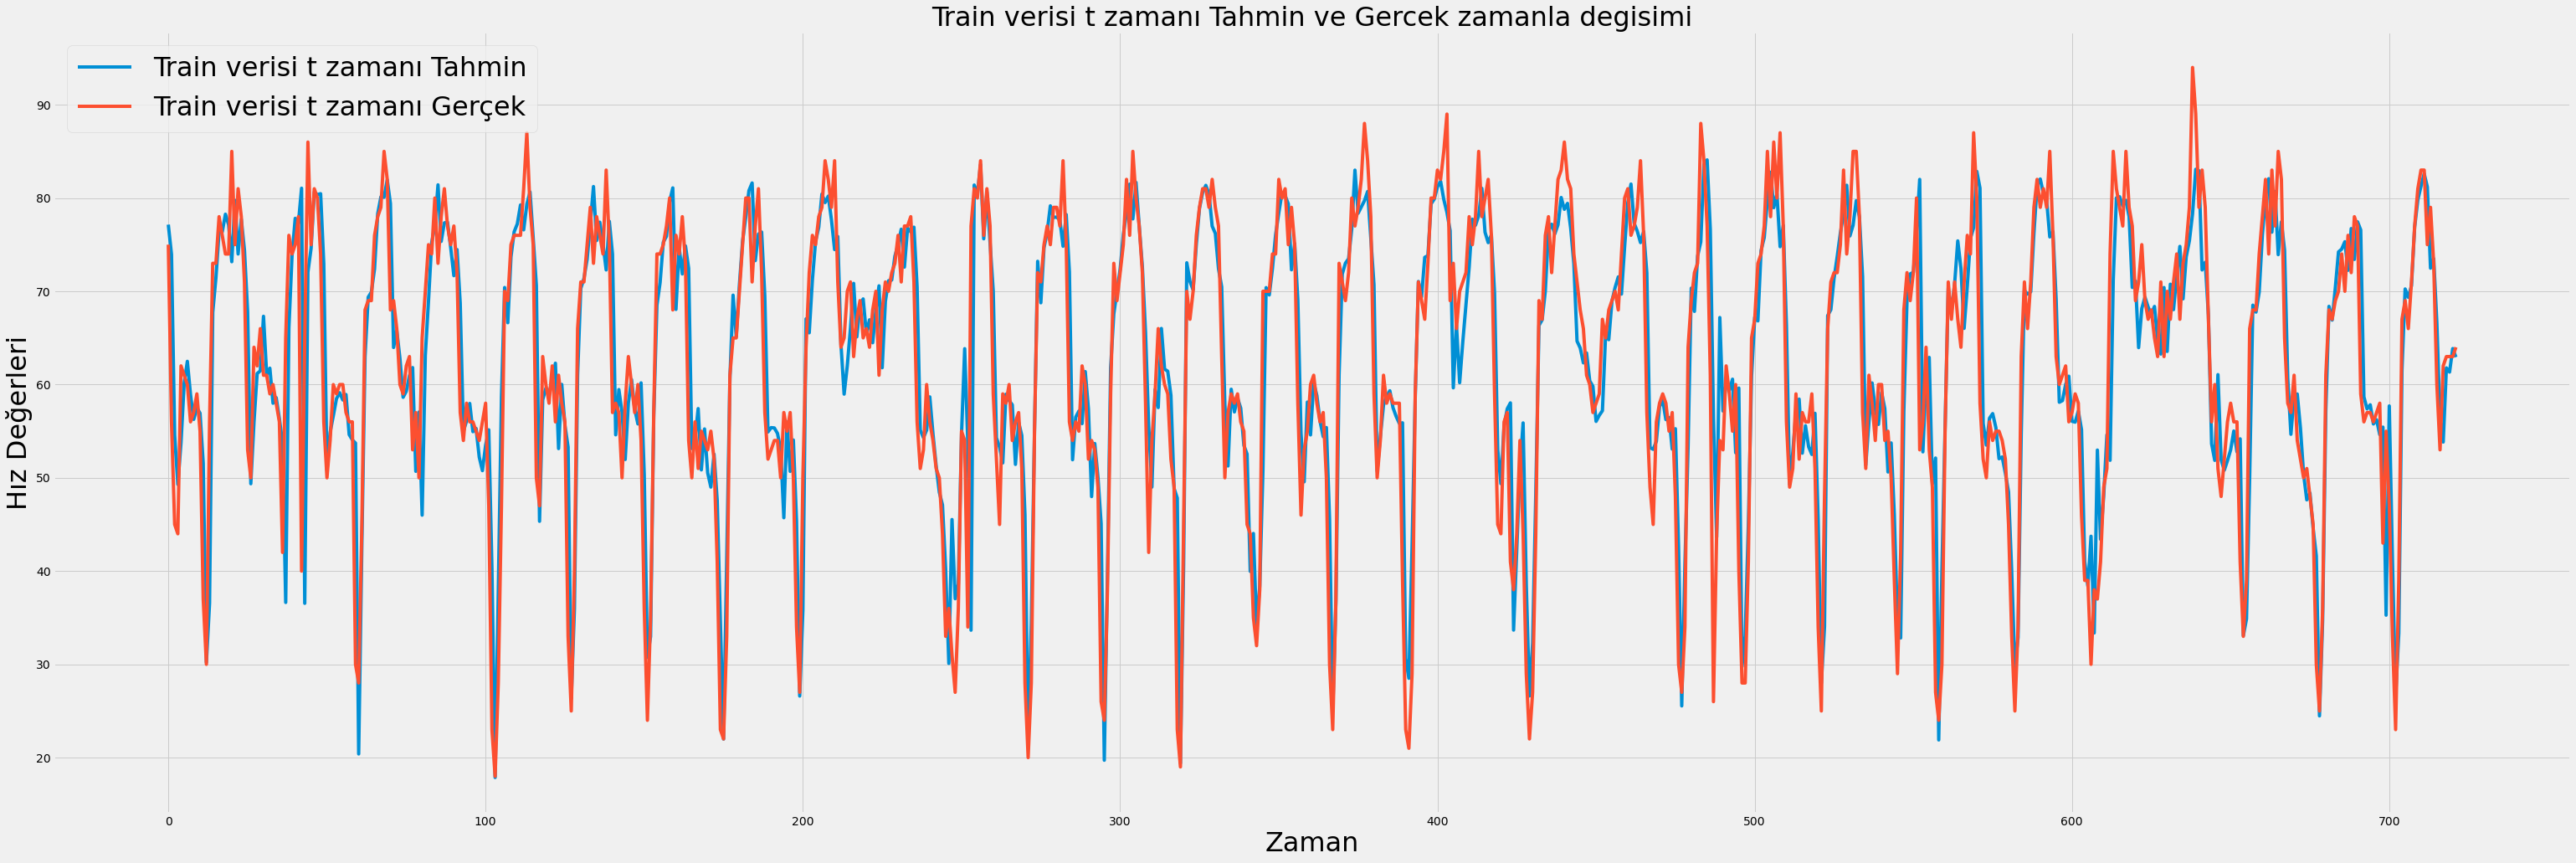

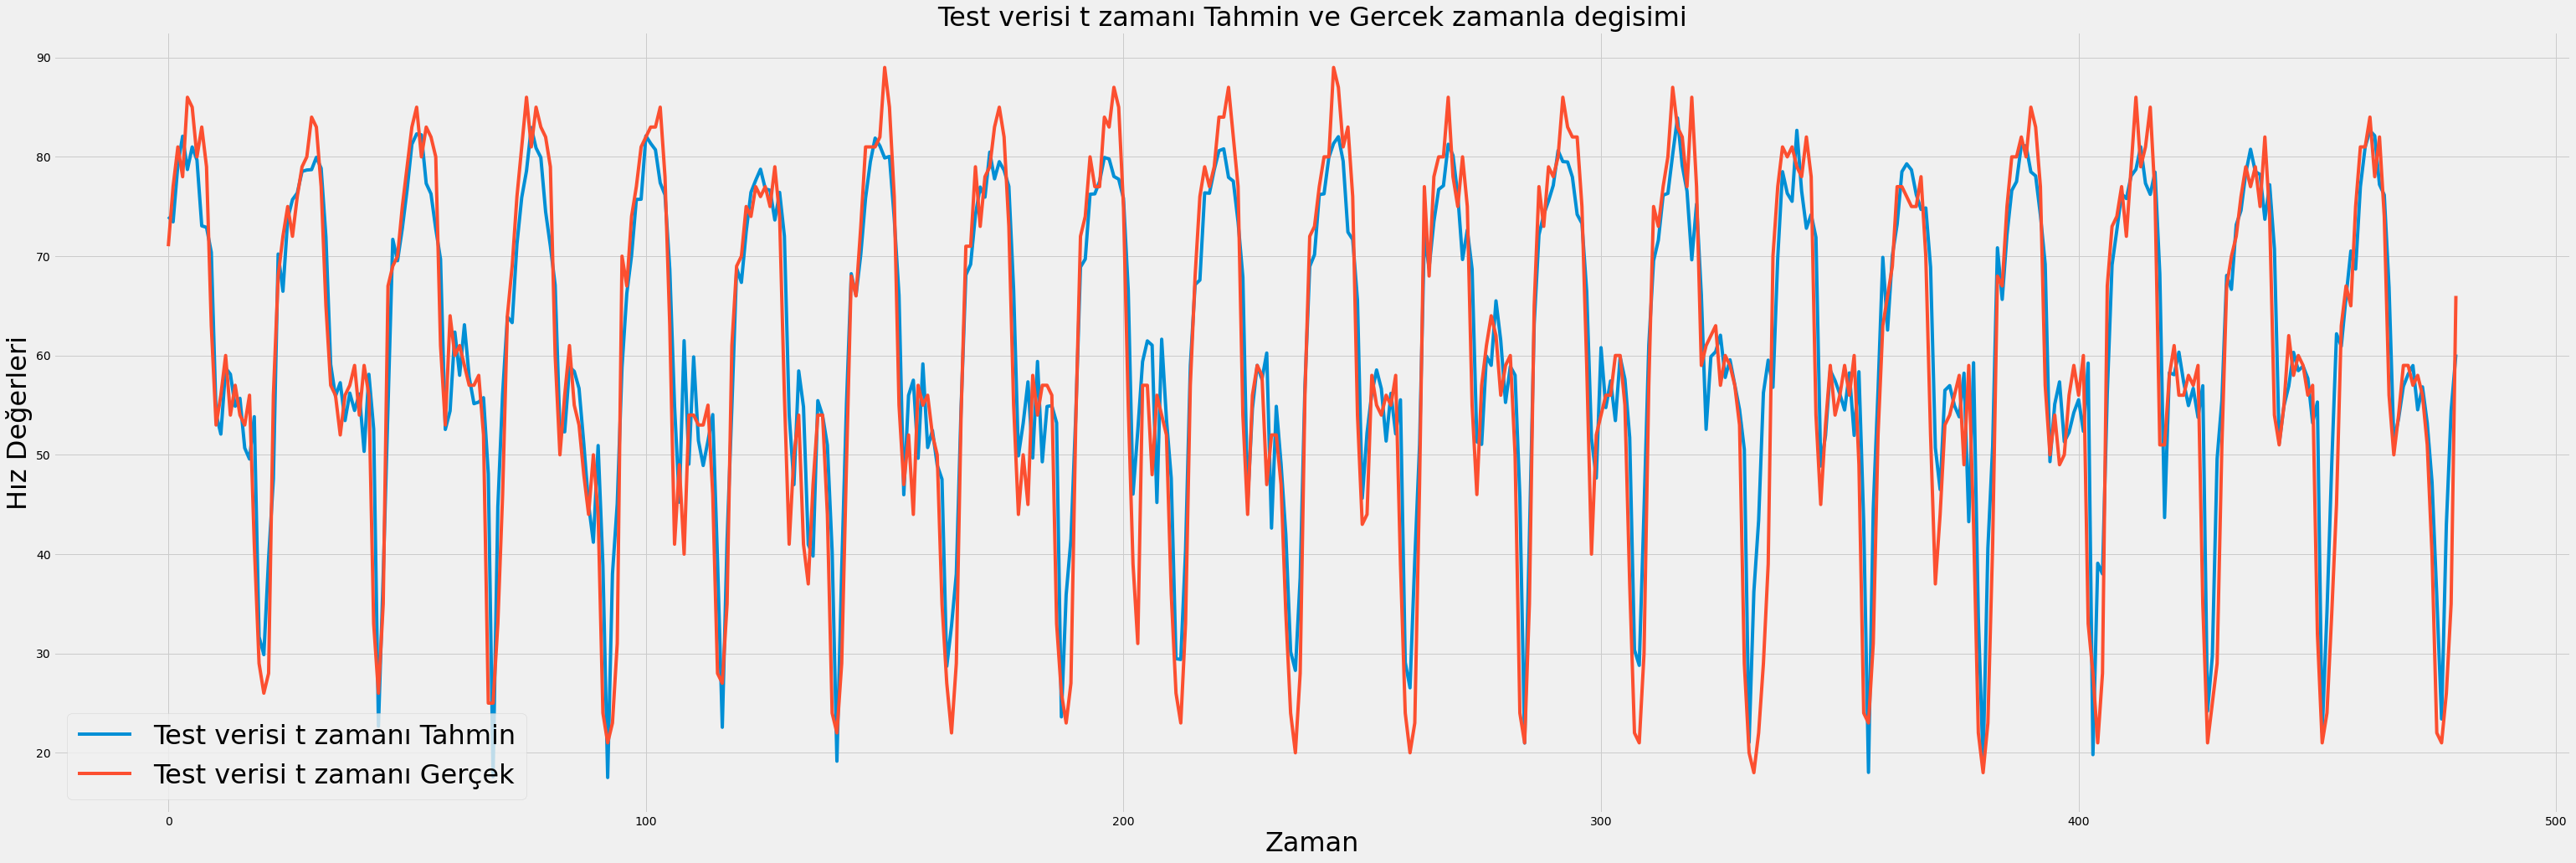

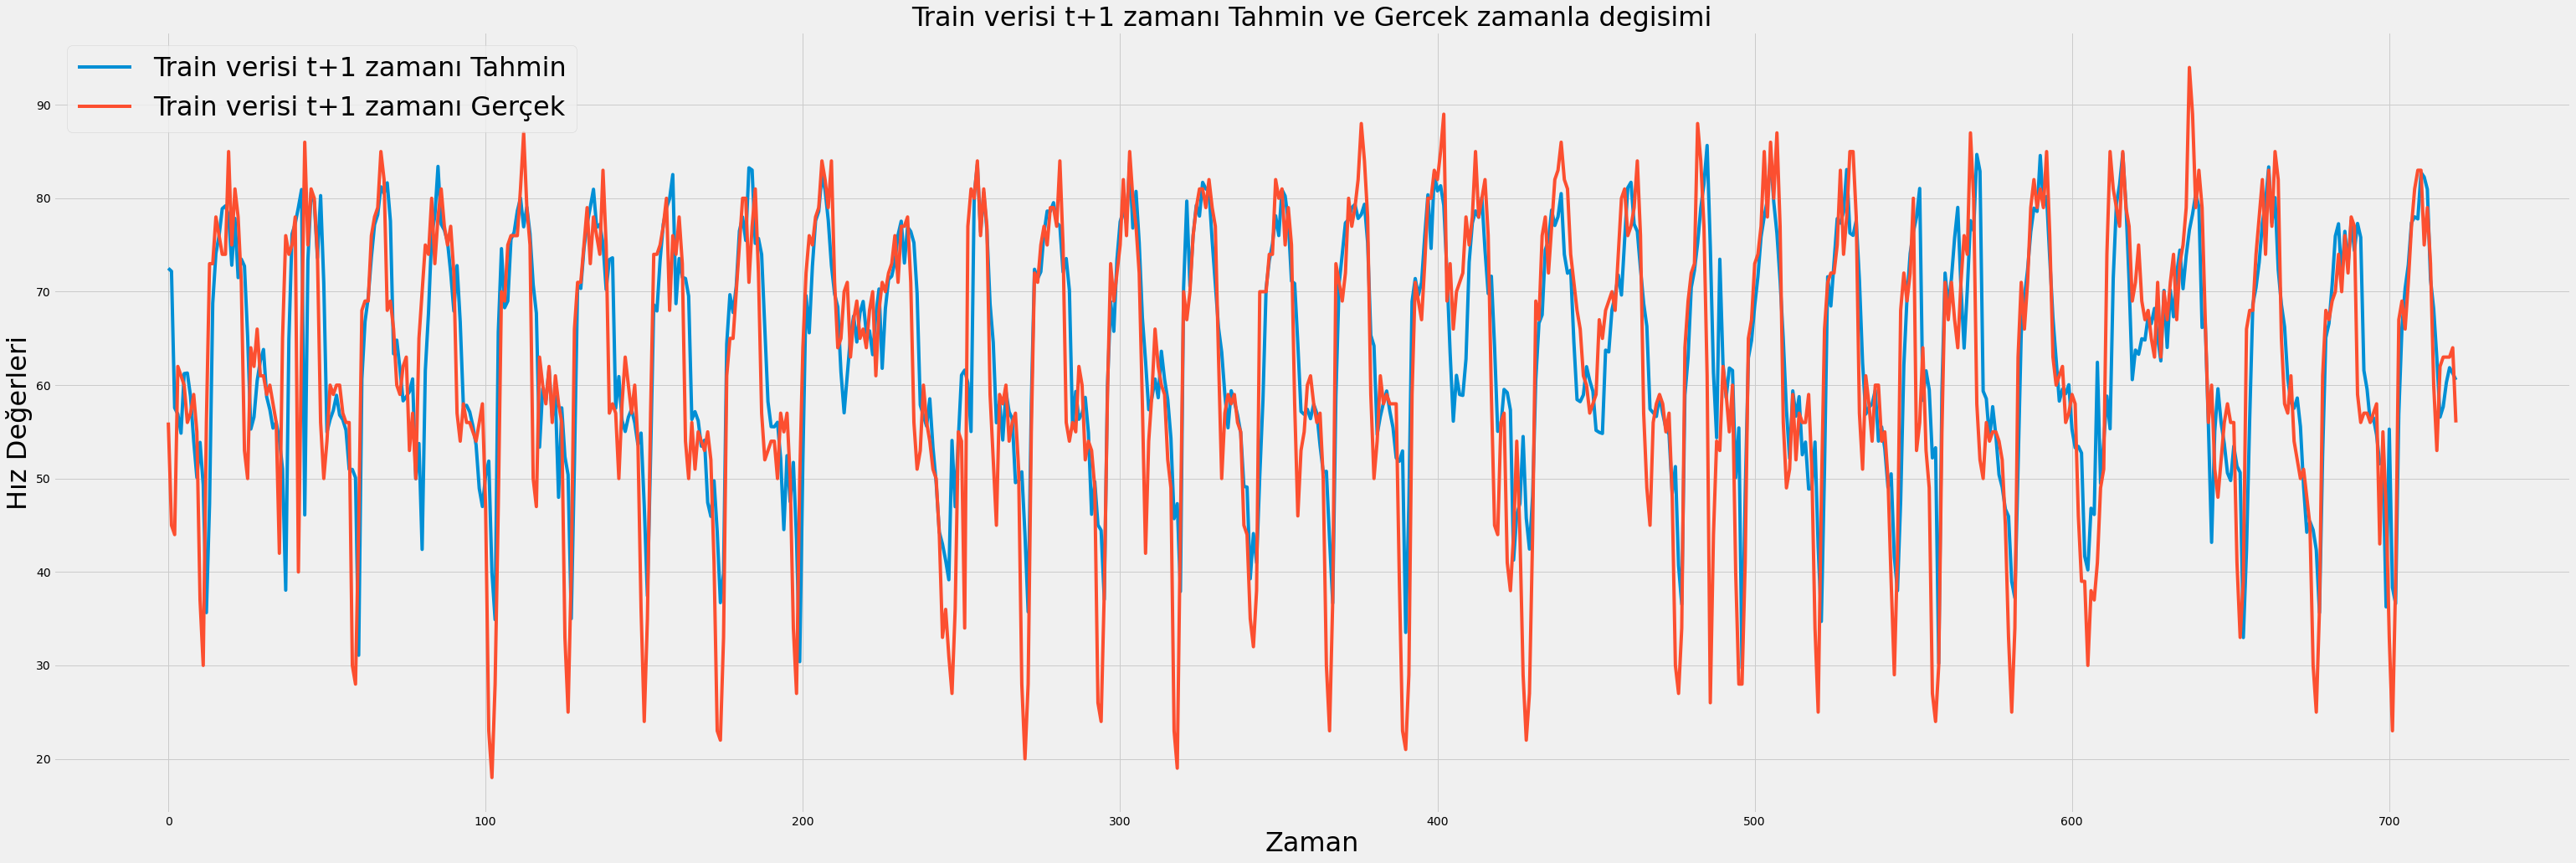

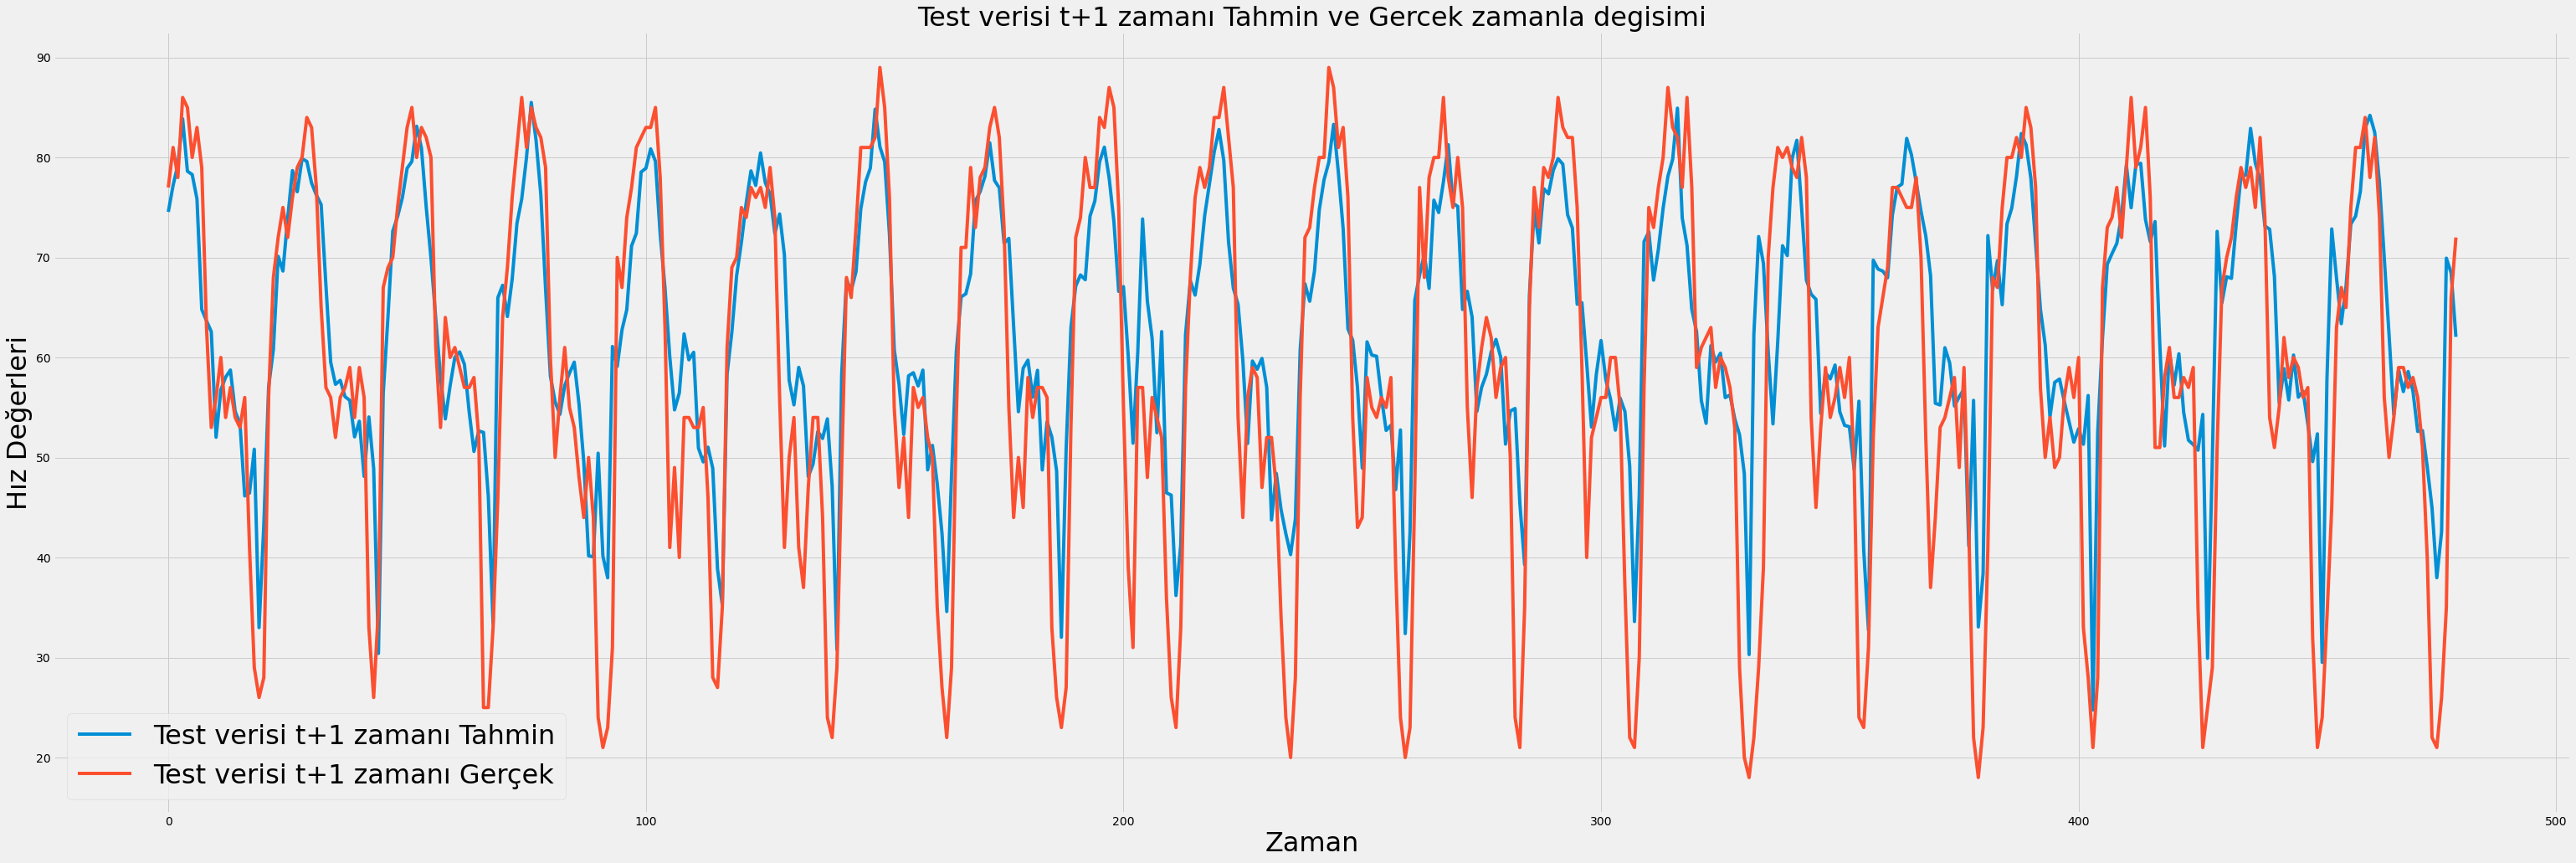

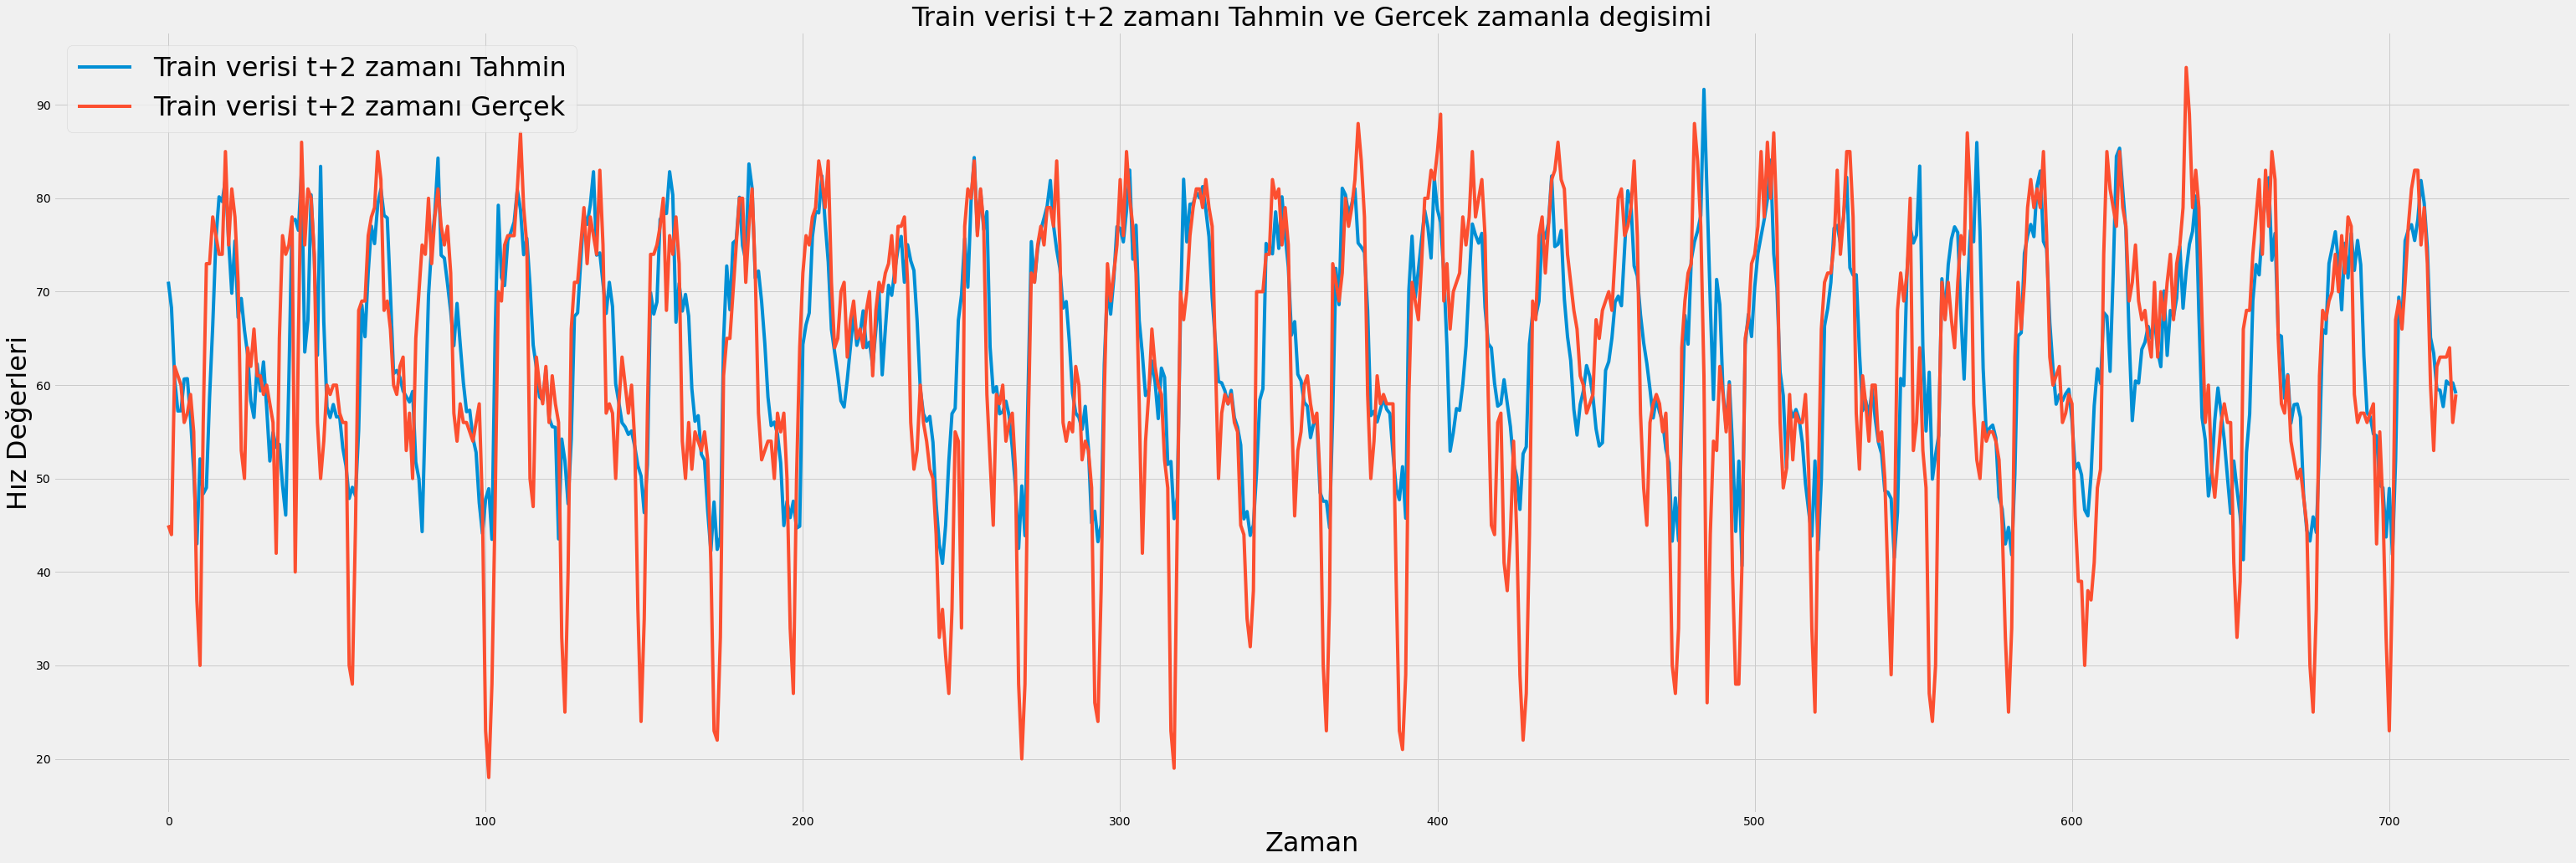

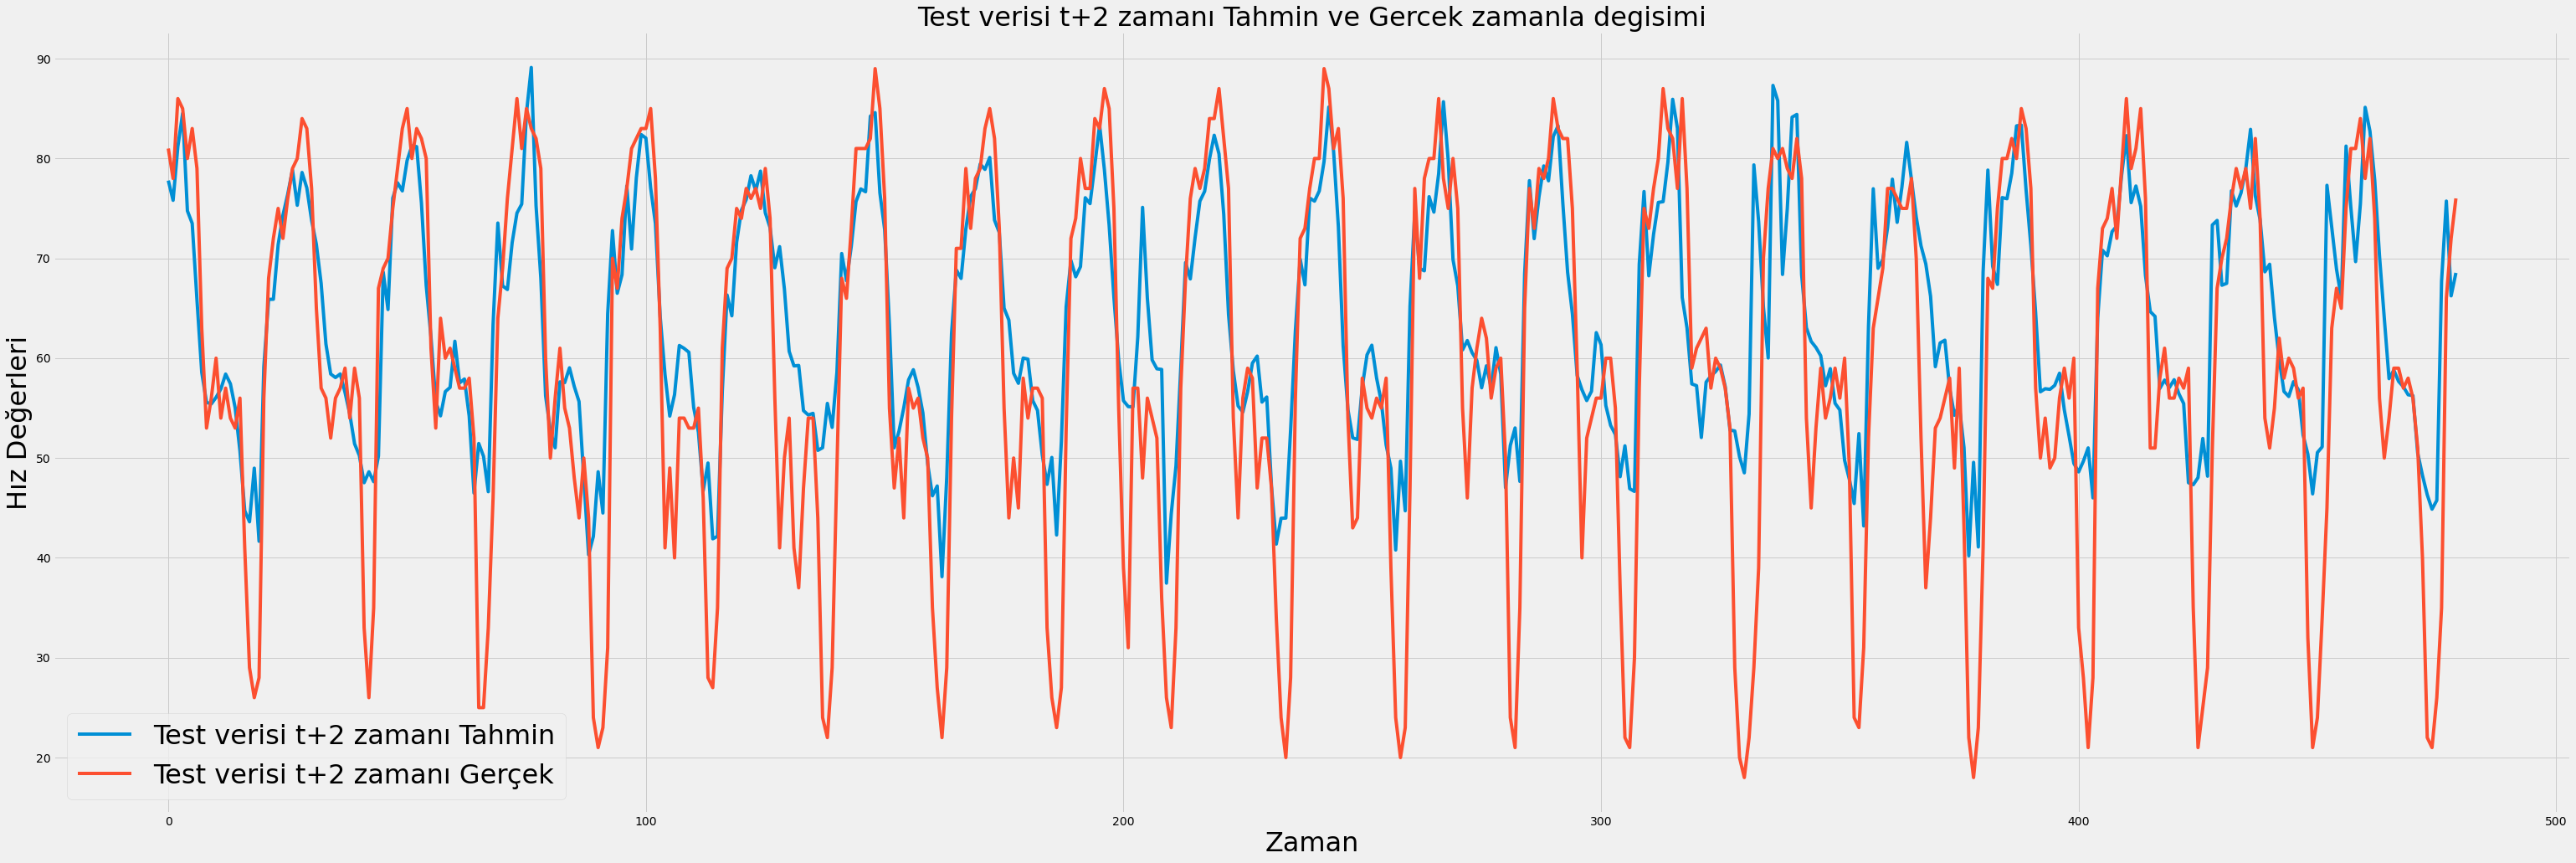

In [25]:
train_y1=train_y[:,0]
pred_train_y1=pred_train_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y1, label = "Train verisi t zamanı Tahmin")
plt.plot(train_y1, label = "Train verisi t zamanı Gerçek")
plt.title('Train verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

test_y1=test_y[:,0]
pred_test_y1=pred_test_y[:,0]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y1, label = "Test verisi t zamanı Tahmin")
plt.plot(test_y1, label = "Test verisi t zamanı Gerçek")
plt.title('Test verisi t zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y2=train_y[:,1]
pred_train_y2=pred_train_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y2, label = "Train verisi t+1 zamanı Tahmin")
plt.plot(train_y2, label = "Train verisi t+1 zamanı Gerçek")
plt.title('Train verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y2=test_y[:,1]
pred_test_y2=pred_test_y[:,1]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y2, label = "Test verisi t+1 zamanı Tahmin")
plt.plot(test_y2, label = "Test verisi t+1 zamanı Gerçek")
plt.title('Test verisi t+1 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')

train_y3=train_y[:,2]
pred_train_y3=pred_train_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_train_y3, label = "Train verisi t+2 zamanı Tahmin")
plt.plot(train_y3, label = "Train verisi t+2 zamanı Gerçek")
plt.title('Train verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')


test_y3=test_y[:,2]
pred_test_y3=pred_test_y[:,2]
plt.figure(figsize=(48, 16))
plt.plot(pred_test_y3, label = "Test verisi t+2 zamanı Tahmin")
plt.plot(test_y3, label = "Test verisi t+2 zamanı Gerçek")
plt.title('Test verisi t+2 zamanı Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
#plt.show()
plt.savefig('MLP_Mnas_15k_iter.png')